# Project 2 - Predicting traffic

**Authors**: Tellev Sundt (tsu012) and Johanna Jøsang (fak006)

## Setup

In [18]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import ensemble as ens
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
import datetime
from datetime import timedelta
import calendar

In [19]:
# Import data from .csv file
traffic_data = pd.read_csv("data.csv")
print(traffic_data)

         År  Måned  Dag  Fra_time  Volum til SNTR  Volum til DNP  Volum totalt
0      2015     12   16        11             265            232           497
1      2015     12   16        12             243            223           466
2      2015     12   16        13             251            289           540
3      2015     12   16        14             369            409           778
4      2015     12   16        15             283            365           648
...     ...    ...  ...       ...             ...            ...           ...
35187  2019     12   31        19              77             72           149
35188  2019     12   31        20              58             61           119
35189  2019     12   31        21              52             51           103
35190  2019     12   31        22              51             39            90
35191  2019     12   31        23              34             81           115

[35192 rows x 7 columns]



## Visualisation

To get a first general impression on how to the total trafficvolume varied over the years, so we plotted all the data in a graph with a longx-axis.

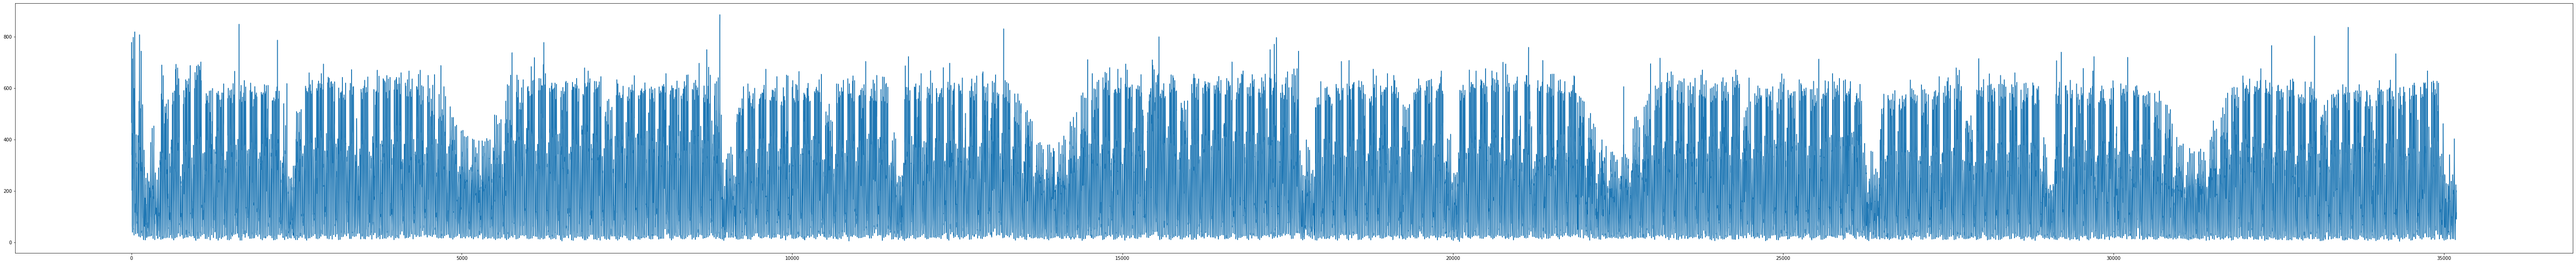

In [20]:
# Plot all the total traffic per hour over time to give a holistic impression of the data
y_volum_totalt = traffic_data['Volum totalt']
x_data_index = list(range(0, len(y_volum_totalt)))
fig = plt.figure(figsize=(100,10))
plt.plot(x_data_index, y_volum_totalt)
plt.show()
#It looks like there is a tendency for the traffic to slow down at around the same time each year

In [21]:
#Let us have a look at the individual years
year_2015 = traffic_data[traffic_data['År'] == 2015]
year_2016 = traffic_data[traffic_data['År'] == 2016]
year_2017 = traffic_data[traffic_data['År'] == 2017]
year_2018 = traffic_data[traffic_data['År'] == 2018]
year_2019 = traffic_data[traffic_data['År'] == 2019]

print("Length of data from 2015:", len(year_2015))
print("Length of data from 2016:", len(year_2016))
print("Length of data from 2017:", len(year_2017))
print("Length of data from 2018:", len(year_2018))
print("Length of data from 2019:", len(year_2019))

Length of data from 2015: 373
Length of data from 2016: 8758
Length of data from 2017: 8760
Length of data from 2018: 8545
Length of data from 2019: 8756


We can see that the data size is not identical for each year, ie we don't have a value for the traffic at every hour for every year. However 2016-2019 seem to have about the same amount of data. 

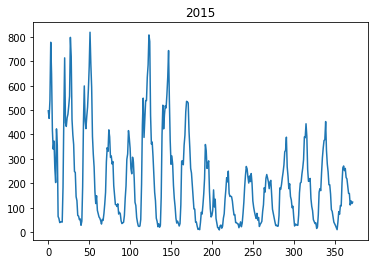

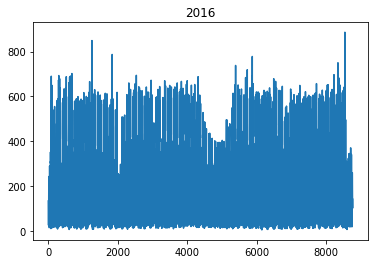

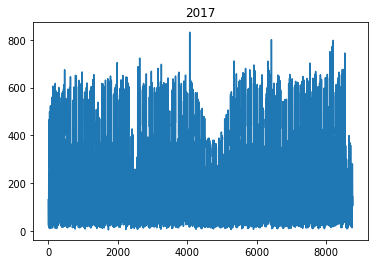

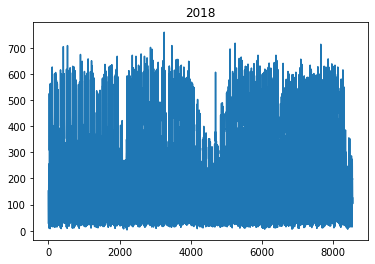

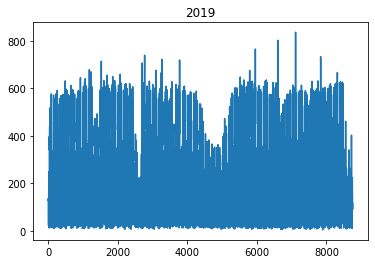

In [22]:
def plot_traffic_data_for_year(year_string, year_data):
    """
    Plots the total traffic volume in a year. X-axis is simply the index of the datapoint.
    
    :param year_string: string of the year we are plotting
    :param year_data: section of the dataframe containing the data for the year we are plotting
    """
    x = list(range(0, len(year_data)))
    y = year_data['Volum totalt']
    plt.plot(x,y)
    plt.title(year_string)
    plt.show()
    
plot_traffic_data_for_year("2015", year_2015)
plot_traffic_data_for_year("2016", year_2016)
plot_traffic_data_for_year("2017", year_2017)
plot_traffic_data_for_year("2018", year_2018)
plot_traffic_data_for_year("2019", year_2019)

After splitting the data by year, and plotting the data for each year individually we could see that the shape of the data for each year was quite similar. Unfortunately we did not have a full year of data for 2015, but looking at 2016-2019 was enough to see the similarity in each year.

Up until now we had simply plotted one data point after the other, so the x-axis merely represented the index for each data point. This doesn't give us enough insight into the data, so we changed the x-axis to represent time intervals.

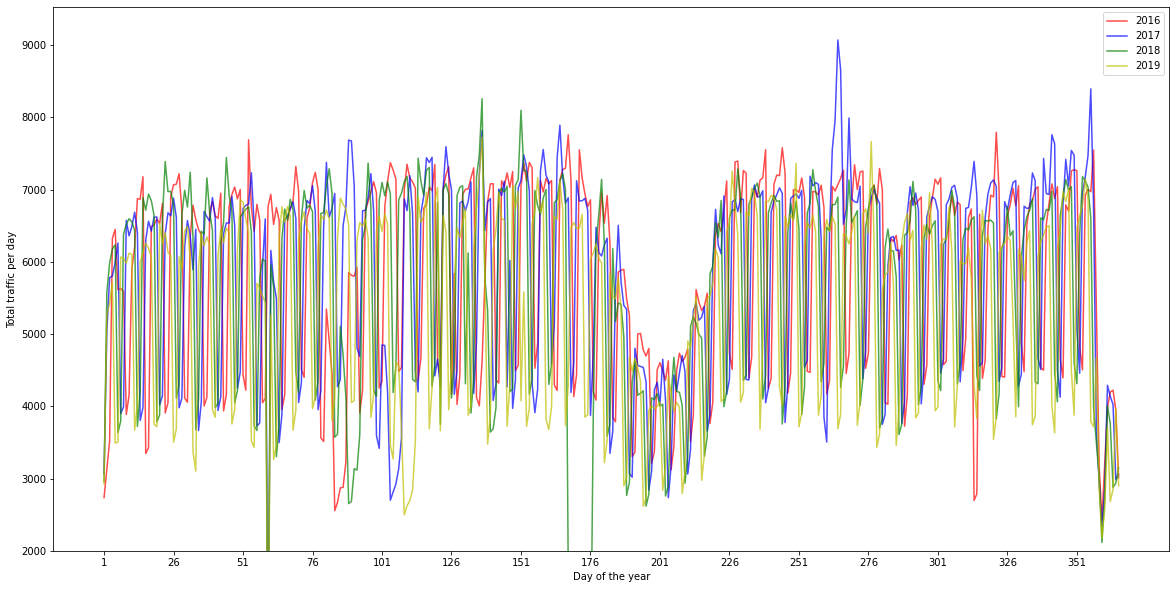

In [23]:
#Since it is a bit difficult to tell the average traffic per day with the data represented like this, we can try to get total traffic per day instead of per hour

def get_total_traffic_per_day(td_dataframe):
    """
    Gernerates a list of total traffic per day, where the index corresponds to the day number +1.
    
    :param td_dataframe: dataframe of traffic data, or a subset of the dataframe (fex data for a year)
    """
    totat_traffic_per_day = np.ones(367)
    for i in range(len(td_dataframe)):
        hour_datapoint = td_dataframe.iloc[i]
        month_number = int(hour_datapoint[1])
        day_number = int(hour_datapoint[2])
        day_of_the_year = datetime.datetime(2016, month_number, day_number).timetuple().tm_yday #retrieve day number
        totat_traffic_per_day[day_of_the_year] += hour_datapoint[6] #add traffic that hour to the total traffic per day
    return totat_traffic_per_day

#generate lists of total traffic per day for the years
total_traffic_per_day_2016 = get_total_traffic_per_day(year_2016)[1:] #removing day 0, as it contains no data
total_traffic_per_day_2017 = get_total_traffic_per_day(year_2017)[1:]
total_traffic_per_day_2018 = get_total_traffic_per_day(year_2018)[1:]
total_traffic_per_day_2019 = get_total_traffic_per_day(year_2019)[1:]

x_days_total = list(range(1, len(total_traffic_per_day_2016)+1))


#plotting the traffic pr day
fig = plt.figure(figsize=(20,10))
plt.plot(x_days_total,total_traffic_per_day_2016, 'r-', alpha = 0.7, label = "2016")
plt.plot(x_days_total,total_traffic_per_day_2017, 'b-', alpha = 0.7, label = "2017")
plt.plot(x_days_total,total_traffic_per_day_2018, 'g-', alpha = 0.7, label = "2018")
plt.plot(x_days_total,total_traffic_per_day_2019, 'y-', alpha = 0.7, label = "2019")

plt.xticks(np.arange(min(x_days_total), max(x_days_total)+1, 25))
plt.ylim(bottom=2000)
plt.xlabel("Day of the year")
plt.ylabel("Total traffic per day")
plt.legend()
plt.show()

While we can se a consistent trend, we would like to extract a bit more information from the data, such as the day of
the year and what weekday each datapoint has. Therefore we construct a list of the traffic data represented in datetime format.

In [24]:
datetime_representation_of_today = datetime.datetime.today()
print("Datetime representation of today:", datetime_representation_of_today)

def generate_datetime_array_from_traffic_data(traffic_data_input):
    #initialize np array to store datetime of each datapoint in traffic_data
    traffic_data_datetime = np.full(len(traffic_data_input), datetime_representation_of_today)
    for i in range(len(traffic_data_input)):
        data_point = traffic_data_input.iloc[i]
        datetime_representation_of_datapoint = datetime.datetime(data_point[0], data_point[1], data_point[2],data_point[3])
        traffic_data_datetime[i] = datetime_representation_of_datapoint
    return traffic_data_datetime

traffic_data_datetime = generate_datetime_array_from_traffic_data(traffic_data)
print("Datetime represenation of traffic data:")
print(traffic_data_datetime)

Datetime representation of today: 2020-10-09 22:31:54.396492
Datetime represenation of traffic data:
[datetime.datetime(2015, 12, 16, 11, 0)
 datetime.datetime(2015, 12, 16, 12, 0)
 datetime.datetime(2015, 12, 16, 13, 0) ...
 datetime.datetime(2019, 12, 31, 21, 0)
 datetime.datetime(2019, 12, 31, 22, 0)
 datetime.datetime(2019, 12, 31, 23, 0)]


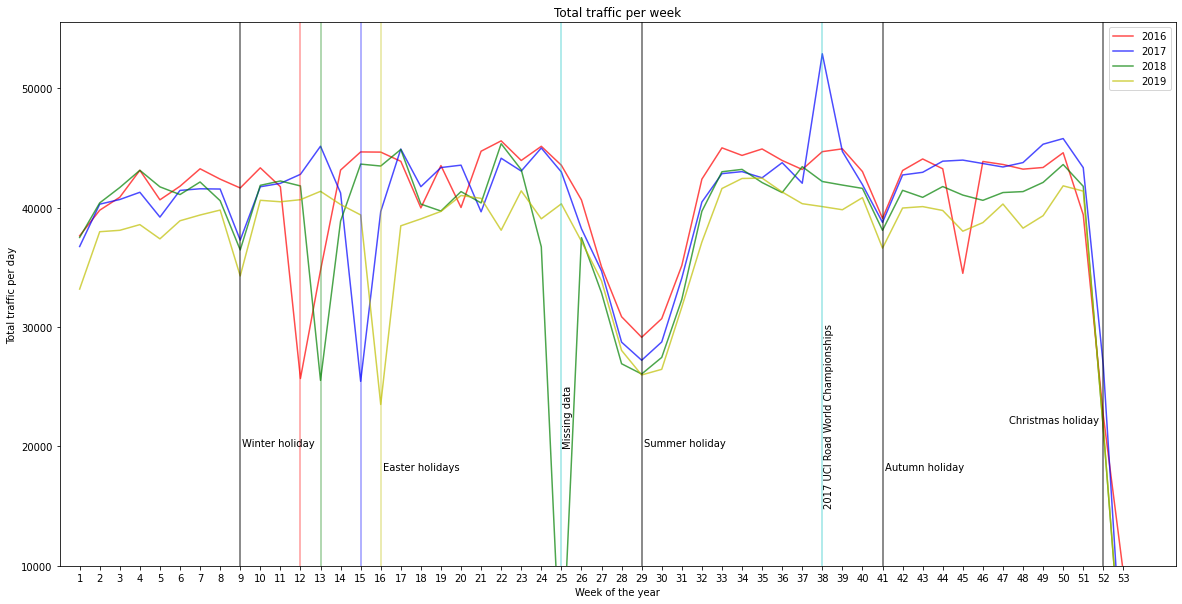

In [25]:
#It is still a bit distracting to see the fluctuation between weekends and weekdays, so we'll take total traffic per week

def get_total_traffic_per_week(traffic_data):
    """
    Gernerates a list of total traffic per day, where the index corresponds to the day number +1.
    
    :param traffic_data: dataframe of traffic data, or a subset of the dataframe (fex data for a year)
    """
    total_traffic_per_week = np.ones(54)
    for i in range(len(traffic_data)):
        hour_datapoint = traffic_data.iloc[i]
        year_number = hour_datapoint[0]
        month_number = hour_datapoint[1]
        day_number = hour_datapoint[2]
        week_number = datetime.datetime(year_number, month_number, day_number).isocalendar()[1]
        total_traffic_per_week[week_number] += hour_datapoint[6] #add traffic that hour to the total traffic per day
    return total_traffic_per_week

#generate lists of total traffic per day for the years
total_traffic_per_week_2016 = get_total_traffic_per_week(year_2016)[1:] #removing week 0, as it contains no data
total_traffic_per_week_2017 = get_total_traffic_per_week(year_2017)[1:]
total_traffic_per_week_2018 = get_total_traffic_per_week(year_2018)[1:]
total_traffic_per_week_2019 = get_total_traffic_per_week(year_2019)[1:]

x_value_weeks_total = list(range(1, len(total_traffic_per_week_2016)+1))

#plotting the traffic pr day
fig = plt.figure(figsize=(20,10))
plt.plot(x_value_weeks_total,total_traffic_per_week_2016, 'r-', alpha = 0.7, label = "2016")
plt.plot(x_value_weeks_total,total_traffic_per_week_2017, 'b-', alpha = 0.7, label = "2017")
plt.plot(x_value_weeks_total,total_traffic_per_week_2018, 'g-', alpha = 0.7, label = "2018")
plt.plot(x_value_weeks_total,total_traffic_per_week_2019, 'y-', alpha = 0.7, label = "2019")
# Marking seasonal holidays
plt.axvline(x=9, ymin=0, ymax=60000, color = 'k',alpha = 0.6)
plt.text(9.1,20000,'Winter holiday')
plt.axvline(x=41, ymin=0, ymax=60000, color = 'k', alpha = 0.6)
plt.text(41.1,18000,'Autumn holiday')
plt.axvline(x=52, ymin=0, ymax=60000, color = 'k', alpha = 0.6)
plt.text(47.3,22000,'Christmas holiday')
plt.axvline(x=29, ymin=0, ymax=60000, color = 'k', alpha = 0.6)
plt.text(29.1,20000,'Summer holiday')

# Marking easter holidays
plt.axvline(x=12, ymin=0, ymax=60000, color = 'r', alpha = 0.4)
plt.axvline(x=13, ymin=0, ymax=60000, color = 'g', alpha = 0.4)
plt.axvline(x=15, ymin=0, ymax=60000, color = 'b', alpha = 0.4)
plt.axvline(x=16, ymin=0, ymax=60000, color = 'y', alpha = 0.4)
plt.text(16.1,18000,'Easter holidays')

# Marking outlier
plt.axvline(x=38, ymin=0, ymax=60000, color = 'c', alpha = 0.4)
plt.text(38.1, 15000, "2017 UCI Road World Championships", rotation = "90")
# Marking outlier
plt.axvline(x=25, ymin=0, ymax=60000, color = 'c', alpha = 0.4)
plt.text(25.1, 20000, "Missing data", rotation = "90")


# Adding labels
plt.xticks(np.arange(min(x_value_weeks_total), max(x_value_weeks_total)+1, 1))
plt.xlim(left=0)
plt.ylim(bottom=10000)
plt.xlabel("Week of the year")
plt.ylabel("Total traffic per day")
plt.title("Total traffic per week")
plt.legend()
plt.show()

The black vertical lines represent condistent holidays that appear to fall on the same time every year. Unfortunately
easter falls on different weeks every year, but we will mark then as "holiday" too. There is some data missing around
week 25, but this has no effect even though it looks like it on the graph. Had the graph represented "average traffic
per week" there would be no dip in traffic.

In week 38 in 2017, however, there was a big sports event in Bergen, so this is a true outlier which will have an
effect on the model.

Overall we can see that the week number has a lot to say for the fluctuation of data, so it may be an idea to add it as a feature.

Now the similarity is traffic for each year was a lot easier to identify, and it was possible to clearly mark holidays on the graph.
Being content with our understanding of the large-scale cycles in the data, we will now a look at the cycles that happen in a day. We plot the mean total traffic per day of the week, in addition to the mean of the in- and out-traffic from the city centre.

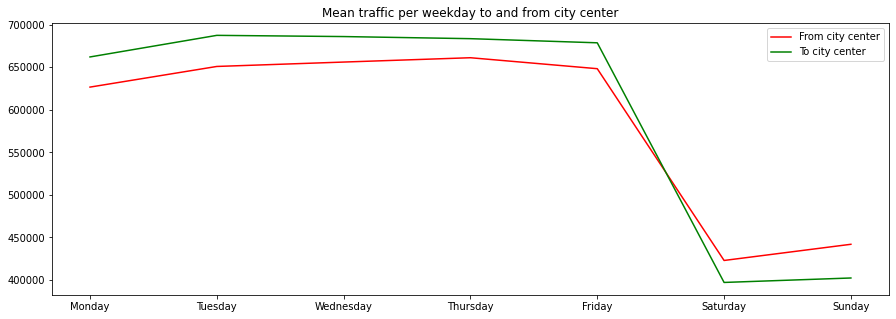

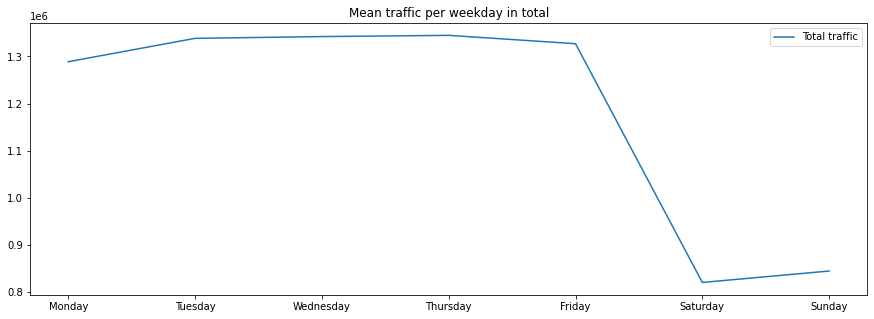

In [26]:
def weekend_generator(traffic_dataframe, traffic_datetime):
    weekdays_to_SNTR = [0]*7
    weekdays_to_DNP = [0]*7
    weekdays_total = [0]*7
    weekends = []
    
    for i in range(len(traffic_dataframe)):
        data_point = traffic_dataframe.iloc[i]
        weekday = traffic_datetime[i].weekday()
        weekends.append(int(weekday > 4))  # Adding to one-hot "isWeekend"
        weekdays_to_SNTR[weekday] += data_point[4]
        weekdays_to_DNP[weekday] += data_point[5]
        weekdays_total[weekday] += data_point[6]
    return weekends, weekdays_to_DNP, weekdays_to_SNTR, weekdays_total

(wknds, to_DNP, to_SNTR, tot) = weekend_generator(traffic_data, traffic_data_datetime)

day_names = list(calendar.day_name)
fig = plt.figure(figsize=(15,5))
plt.plot(day_names, to_DNP, c = 'r', label ="From city center")
plt.plot(day_names, to_SNTR, c = 'g', label = "To city center")
plt.title("Mean traffic per weekday to and from city center")
plt.legend()
plt.show()

day_names = list(calendar.day_name)
fig = plt.figure(figsize=(15,5))
plt.plot(day_names, tot, label ="Total traffic")
plt.title("Mean traffic per weekday in total")
plt.legend()
plt.show()

is_weekend = wknds

From this we can confirm what was assumed, namely a considerable drop in traffic on the weekends, and otherwise a relatively consistent level of traffic in the weekdays.
Finally we want to look at the traffic throughout the day, so we plot the mean traffic per hour of the day.

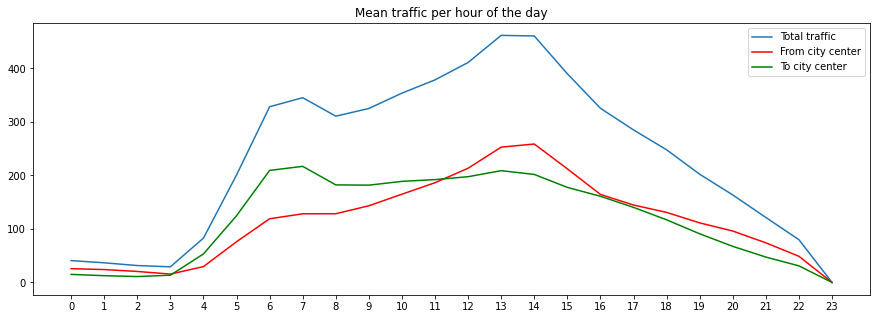

In [27]:
#Now let us look at the traffic for each hour of the day, and compare the traffic in and out of town

def get_total_traffic_per_hour_of_day(string_label):
    y_per_hour = np.zeros(24)
    for i in range(0, 23):
        traffic_per_hour_i = traffic_data[traffic_data['Fra_time'] == i]
        mean_pr_hour = np.mean(traffic_per_hour_i[string_label])
        y_per_hour[i] = mean_pr_hour
    return y_per_hour

y_total_per_hour = get_total_traffic_per_hour_of_day('Volum totalt')
y_to_DNP_per_hour = get_total_traffic_per_hour_of_day('Volum til DNP')
y_to_SNTR_per_hour = get_total_traffic_per_hour_of_day('Volum til SNTR')

x_hour_number = list(range(0, 24))
fig = plt.figure(figsize=(15,5))
plt.plot(x_hour_number,y_total_per_hour, label ="Total traffic")
plt.plot(x_hour_number,y_to_DNP_per_hour, c = 'r', label ="From city center")
plt.plot(x_hour_number,y_to_SNTR_per_hour, c = 'g', label = "To city center")
plt.title("Mean traffic per hour of the day")
plt.xticks(np.arange(min(x_hour_number), max(x_hour_number)+1, 1.0))
plt.legend()
plt.show()


This looks as expected, with traffic to the city center peaking in the morning and traffic from the city center peaking in the afternoon. The total volume of traffic peaks a bit past, and the traffic volume slowed down to very low numbers in the middle of the night.

Being content with our understanding of the data, we now continue with feature engineering.

## Feature engineering

### Holiday
We know that during holidays there is less traffic, and we could see this in the data too. Therefore we decided to add an "is holiday" feature, which was 1 for a datapoint that was considerered to be in a holiday, and 0 otherwise.
Unfortunately we did not come up with an elegant way of finding the holiday intervals, so we manually wrote down the weeks and single days that we considered to be holidays in Bergen.

In [28]:
##### Adding holiday feature to data #####

#Some helper functions
def getDateRangeFromWeek(p_year,p_week): #source: http://mvsourcecode.com/python-how-to-get-date-range-from-week-number-mvsourcecode/
    firstdayofweek = datetime.datetime.strptime(f'{p_year}-W{int(p_week )- 1}-1', "%Y-W%W-%w").date()
    lastdayofweek = firstdayofweek + datetime.timedelta(days=6.9)
    return firstdayofweek, lastdayofweek

def extract_holiday_dates(holdiday_year, holiday_week): #source: https://stackoverflow.com/questions/7274267/print-all-day-dates-between-two-dates
    holiday_dates = np.full(7, datetime_representation_of_today) #initialize list to store holiday dated
    firstdate, lastdate =  getDateRangeFromWeek(holdiday_year,holiday_week)
    delta =  lastdate - firstdate       # as timedelta
    for i in range(delta.days + 1):
        holiday_day = firstdate + timedelta(days=i)
        holiday_dates[i] = holiday_day
    return holiday_dates

def holidays(year_from, year_to):
    holidays_list = []
    # The week number of holidays is based on information from Bergen Kommune, timeanddate.no and the graph above
    winter_holiday_week_number = 9
    summer_holiday_week_number_range = list(range(26, 33))
    autumn_holiday_week_number = 41
    christmas_holiday_week_number_range = list(range(52, 54))

    # Add the holiday dates for years 2015-2019
    for year in range(year_from, year_to):
        winter_holiday_dates = extract_holiday_dates(year, winter_holiday_week_number)
        autumn_holiday_dates = extract_holiday_dates(year, autumn_holiday_week_number)

        summer_holiday_dates = []
        for week in summer_holiday_week_number_range:
            new_summer_holiday_dates = extract_holiday_dates(year, week)
            summer_holiday_dates = np.concatenate([summer_holiday_dates, new_summer_holiday_dates])

        christmas_holiday_dates = []
        for week in christmas_holiday_week_number_range:
            new_christmas_holiday_dates = extract_holiday_dates(year, week)
            christmas_holiday_dates = np.concatenate([christmas_holiday_dates, new_christmas_holiday_dates])

        holidays_list = np.concatenate([holidays_list, winter_holiday_dates, summer_holiday_dates, autumn_holiday_dates, christmas_holiday_dates]) # add holiday dates for the year
    return holidays_list


#First we want to make a list of days that we define as "holiday days". We will base this on the holidays identified in the graph above.
holiday_dates = holidays(2015, 2020)
holiday_dates = np.concatenate([holiday_dates,
[datetime.date(2015, 12, 28), datetime.date(2015, 12, 29), datetime.date(2015, 12, 30),
 datetime.date(2015, 12, 31), datetime.date(2016, 1, 1), datetime.date(2016, 12, 26),
 datetime.date(2016, 12, 27), datetime.date(2016, 12, 28), datetime.date(2016, 12, 29),
 datetime.date(2016, 12, 30), datetime.date(2016, 12, 31), datetime.date(2017, 1, 1),
 datetime.date(2018, 1, 1), datetime.date(2018, 12, 31), datetime.date(2019, 1, 1),
 datetime.date(2019, 12, 30), datetime.date(2019, 12, 31)]])

# Add the easter weeks separately, as the week of the holiday varies from year to year
holiday_dates = np.concatenate([holiday_dates, 
                                extract_holiday_dates(2016, 13), # dates for easter 2016
                                extract_holiday_dates(2017, 16), # dates for easter 2017
                                extract_holiday_dates(2018, 14), # dates for easter 2018
                                extract_holiday_dates(2019, 16)]) # dates for easter 2019


#Now we have a list of holiday dates, and can generate a hot-one encoded feature array for the dataset.

is_holiday = np.zeros(len(traffic_data)) #Feature array for holidays. 1 if the datapoint is in a holiday, 0 otherwise

#This is a brute force method, which definitely could be improved upon
for i in range(len(traffic_data_datetime)):
    for holiday_date in holiday_dates:
        if traffic_data_datetime[i].date() == holiday_date:
            is_holiday[i] = 1
            continue

traffic_data['is_holiday'] = is_holiday #add "is_holiday" column to traffic_data dataframe

### Cyclical nature of hours and days
We want to convey the cyclic nature of the hours of the day, and unfortunately the way the hours are represented now
gives no indication that the 23rd hour is close to the 0th hour. To solve this we will use two triginometric functions
sin((2t*pi)/24) and sin((2t*pi)/24), where t is the hour of the day. We add two features one with sin and the other
with cos, because if we only used one of the two, then two hours in the day would have the exact same value, indicating
a relationship where there is none.

We do the same with days of the year.

In [29]:
def sin_cos_for_cycical_values(traffic_data_datetime_input, cycle_size, hour_cycle):
    #first we generate a list values for the two functions, so we can just retrieve the values instead of calculate them each time.
    sin_values = np.ones(cycle_size)
    cos_values = np.ones(cycle_size)
    # fill in lists of sin and cos values
    for t in range(cycle_size):
        sin_values[t] = np.sin((2*t*np.pi) / cycle_size)
        cos_values[t] = np.cos((2*t*np.pi) / cycle_size)

    #initialize new feature columns
    sin_feature = np.zeros(len(traffic_data_datetime_input)) 
    cos_feature = np.zeros(len(traffic_data_datetime_input))
    #Iterate through all the data, and add the correspongind sin and cos values to the feature columns
    for i in range(len(traffic_data_datetime_input)):
        # retrieve either hour or day number
        if (hour_cycle and cycle_size == 24):
            cyclical_number_of_datapoint = traffic_data_datetime_input[i].hour
        elif(not(hour_cycle) and cycle_size == 367):
            cyclical_number_of_datapoint = traffic_data_datetime_input[i].timetuple().tm_yday
        else:
            print("Invalid cycle size:", cycle_size)
            print("TOOOOO")
            return
        sin_feature[i] = sin_values[cyclical_number_of_datapoint]
        cos_feature[i] = cos_values[cyclical_number_of_datapoint]
    return sin_feature, cos_feature

traffic_data['sin_hour'], traffic_data['cos_hour'] = sin_cos_for_cycical_values(traffic_data_datetime, 24, True)
traffic_data['sin_day'], traffic_data['cos_day'] = sin_cos_for_cycical_values(traffic_data_datetime, 367, False)

### Daylight saving time
Since daylight saving time (DST) shifts traffic with one hour, we decided to add the feature "is DST". The feature has value 1 if it is daylight saving time, and 0 otherwise.

In [30]:
traffic_data['is_weekend'] = is_weekend #add "is_weekend" column to traffic_data dataframe
#DST = daylight saving time
#Generate a column for the DST feature, with 1 indicating the datapoint is in DST, and 0 if it is not
DST = []
DST_switch = False
for i in range(len(traffic_data)):
    data_point = traffic_data.iloc[i]
    # TODO: Abstract/refactor the line under
    if data_point[0] == 2016 and data_point[1] == 3 and data_point[2] == 27 and data_point[3] == 2:
        DST_switch = True
    elif data_point[0] == 2016 and data_point[1] == 10 and data_point[2] == 30 and data_point[3] == 3:
        DST_switch = False
    elif data_point[0] == 2017 and data_point[1] == 3 and data_point[2] == 26 and data_point[3] == 2:
        DST_switch = True
    elif data_point[0] == 2017 and data_point[1] == 10 and data_point[2] == 29 and data_point[3] == 3:
        DST_switch = False
    elif data_point[0] == 2018 and data_point[1] == 3 and data_point[2] == 25 and data_point[3] == 2:
        DST_switch = True
    elif data_point[0] == 2018 and data_point[1] == 10 and data_point[2] == 28 and data_point[3] == 3:
        DST_switch = False
    elif data_point[0] == 2019 and data_point[1] == 3 and data_point[2] == 31 and data_point[3] == 2:
        DST_switch = True
    elif data_point[0] == 2019 and data_point[1] == 10 and data_point[2] == 27 and data_point[3] == 3:
        DST_switch = False
    DST.append(int(DST_switch))

traffic_data['is_DST'] = DST #add DST column to traffic_data dataframe

# Model selection

We will be evaluating some models and selecting the most appropriate for:
- Predicting TOTAL traffic volume
- Predicting traffic TO city center
- Predicting traffic FROM city center

These models will be named TOTAL, TO and FROM respectively.

We wanted to use cross validation to get an as unbiased estimator as possible, but since we are using time series data a normal k-fold cross validation may not provide good results. The model is going to be used to predict traffic levels in the future, so by taking a chunk of the data for testing we end up using future data to possibly predict past data. 

In order to avoid this, we use a new method for cross validation which always uses future data for testing. The split method we used is sklearns TimeSeriesSplit. It starts by taking a small partition in the beginning of the dataset for training, and then using a section of the data following for testing. In the next iteration the previous testing data is included in the training, and the next set of data is used for testing.

We thereafter take the average of the mean absolute error for each iteration, in order to get a more unbiased estimator of the score of the models.

When validating the models we will also tweak some hyperparameters.


In [31]:
def validate(train_x, train_y, val_x, val_y, model_type, hyper_p):
    if model_type == "Linear Regression":
        model = LinearRegression()
    elif model_type == "Random Forest":
        model = ens.RandomForestRegressor(max_depth=hyper_p)
    elif model_type == "Decision Tree":
        model = DecisionTreeRegressor(max_depth=hyper_p)
    elif model_type == "Neural Network":
        model = MLPRegressor(hidden_layer_sizes=(hyper_p), random_state=1)  # Relu with Adam
    else:
        raise Exception("Not a valid model")

    model.fit(train_x, train_y)
    pred_y = model.predict(val_x)
    return mean_absolute_error(val_y, pred_y) # MAE

def validate_split_hyperparam(data_x, data_y, model_type, start_p, end_p, p_step=1):
    print("###\t", model_type, "\t###")
    best_mean_MAE = 1000000
    best_hyp_param = -1  #This could be tree depth (Random Forest, Decision Tree) or number of neurons (NN)

    for hyp_param in range(start_p, end_p, p_step):
        list_of_MAE = []
        for train_index, val_index in tscv.split(data_x):
            X_train, X_val = data_x[train_index], data_x[val_index]
            y_train, y_val = data_y[train_index], data_y[val_index]

            MAE = validate(X_train, y_train, X_val, y_val, model_type, hyp_param)
            list_of_MAE.append(MAE)

        mean_MAE = np.mean(list_of_MAE)
        if mean_MAE < best_mean_MAE:
            best_mean_MAE = mean_MAE
            best_hyp_param = hyp_param

    print('Mean MAE: %.3f' %best_mean_MAE)
    return best_hyp_param

## Model selection for predicting TOTAL traffic volume

### Baseline using linear regression - TOTAL

In [32]:
#Use TimeSeriesSplit to split the data into train and test to get accuracies
X = traffic_data[["År", "Måned", "Dag", "Fra_time", "sin_hour", "cos_hour", "sin_day", "cos_day", "is_holiday", "is_weekend", "is_DST"]].values
y = traffic_data["Volum totalt"].values
#Split data into train_val and test data. Do not shuffle the data as it is timeseries data
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

number_of_splits = 4
tscv = TimeSeriesSplit(number_of_splits)

In [33]:
_ = validate_split_hyperparam(X_train_val, y_train_val, "Linear Regression", 0, 1, 1)

###	 Linear Regression 	###
Mean MAE: 68.621


### Random forests - TOTAL

In [34]:
total_best_depth = validate_split_hyperparam(X_train_val, y_train_val, "Random Forest", 1, 20)

###	 Random Forest 	###
Mean MAE: 30.469


In [54]:
print(total_best_depth)

12


### Regression decision tree - TOTAL

In [35]:
best_tree_depth = validate_split_hyperparam(X_train_val, y_train_val, "Decision Tree", 1, 20)

###	 Decision Tree 	###
Mean MAE: 33.847


In [55]:
print(best_tree_depth)

9


### Neural network - TOTAL
This is going to take a while

In [36]:
# Before using NN to make a model, the data should be normalized. Here we squeeze it between 0 and 1:
norm_td = (traffic_data-traffic_data.min()) / (traffic_data.max()-traffic_data.min())

norm_X = norm_td[["År", "Måned", "Dag", "Fra_time", "sin_hour", "cos_hour", "sin_day", "cos_day", "is_holiday", "is_weekend", "is_DST"]].values
norm_y = norm_td["Volum totalt"].values
norm_X_train_val, norm_X_test, norm_y_train_val, norm_y_test = train_test_split(norm_X, norm_y, test_size=0.1, shuffle=False)

#Due to accuracy loss when having more than 320 neurons, we won't iterate up to 1500, to save us a day of computing
best_n_neurons = validate_split_hyperparam(norm_X_train_val, norm_y_train_val, "Neural Network", 10, 500, 10)

###	 Neural Network 	###
Mean MAE: 0.043


In [60]:
print(best_n_neurons)

450


## Testing of selected model for predicting TOTAL traffic volume
Since Random Forest Regressor performed the best after validation, we will only use this model with the best max tree
depth that we found when testing.

In [37]:
forest = ens.RandomForestRegressor(max_depth=total_best_depth)
forest.fit(X_train_val,  y_train_val)
pred_y = forest.predict(X_test)
MAE = mean_absolute_error(y_test, pred_y)

print("On test data, the selected model had a MAE of: %.3f" %MAE)

On test data, the selected model had a MAE of: 25.595


## Model selection for predicting traffic volume TO city center

### Baseline using linear regression - TO

In [38]:
# Setting up the data again
X = traffic_data[["År", "Måned", "Dag", "Fra_time", "sin_hour", "cos_hour", "sin_day", "cos_day", "is_holiday", "is_weekend", "is_DST"]].values
y = traffic_data["Volum til SNTR"].values
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

In [39]:
_ = validate_split_hyperparam(X_train_val, y_train_val, "Linear Regression", 0, 1, 1)

###	 Linear Regression 	###
Mean MAE: 38.889


### Random forests - TO

In [40]:
to_best_depth = validate_split_hyperparam(X_train_val, y_train_val, "Random Forest", 1, 20)

###	 Random Forest 	###
Mean MAE: 16.161


In [53]:
print(to_best_depth)

12


### Regression decision tree - TO

In [41]:
best_tree_depth = validate_split_hyperparam(X_train_val, y_train_val, "Decision Tree", 1, 20)

###	 Decision Tree 	###
Mean MAE: 17.777


In [56]:
print(best_tree_depth)

9


### Neural network - TO

In [42]:
norm_y = norm_td["Volum til SNTR"].values
norm_X_train_val, norm_X_test, norm_y_train_val, norm_y_test = train_test_split(norm_X, norm_y, test_size=0.1, shuffle=False)

best_n_neurons = validate_split_hyperparam(norm_X_train_val, norm_y_train_val, "Neural Network", 10, 500, 10)

###	 Neural Network 	###
Mean MAE: 0.036


In [59]:
print(best_n_neurons)

450


## Testing of selected model for predicting TO traffic volume
Since Random Forest Regressor performed the best after validation, we will only use this model with the best max tree
depth that we found when testing.

In [43]:
forest = ens.RandomForestRegressor(max_depth=to_best_depth)
forest.fit(X_train_val,  y_train_val)
pred_y = forest.predict(X_test)
MAE = mean_absolute_error(y_test, pred_y)

print("On test data, the selected model had a MAE of: %.3f" %MAE)

On test data, the selected model had a MAE of: 13.072


## Model selection for predicting traffic volume FROM city center

### Baseline using linear regression - FROM

In [44]:
# Setting up the data one last time
X = traffic_data[["År", "Måned", "Dag", "Fra_time", "sin_hour", "cos_hour", "sin_day", "cos_day", "is_holiday", "is_weekend", "is_DST"]].values
y = traffic_data["Volum til DNP"].values
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

In [45]:
_ = validate_split_hyperparam(X_train_val, y_train_val, "Linear Regression", 0, 1, 1)

###	 Linear Regression 	###
Mean MAE: 34.579


### Random forests - FROM

In [46]:
from_best_depth = validate_split_hyperparam(X_train_val, y_train_val, "Random Forest", 1, 20)

###	 Random Forest 	###
Mean MAE: 18.342


In [52]:
print(from_best_depth)

10


### Regression decision tree - FROM

In [47]:
best_tree_depth = validate_split_hyperparam(X_train_val, y_train_val, "Decision Tree", 1, 20)

###	 Decision Tree 	###
Mean MAE: 20.228


In [57]:
print(best_tree_depth)

9


### Neural network - FROM
This is going to take a while

In [48]:
norm_y = norm_td["Volum til DNP"].values
norm_X_train_val, norm_X_test, norm_y_train_val, norm_y_test = train_test_split(norm_X, norm_y, test_size=0.1, shuffle=False)

best_n_neurons = validate_split_hyperparam(norm_X_train_val, norm_y_train_val, "Neural Network", 10, 500, 10)

###	 Neural Network 	###
Mean MAE: 0.038


In [58]:
print(best_n_neurons)

450


## Testing of selected model for predicting FROM traffic volume
Since Random Forest Regressor performed the best after validation, we will only use this model with the best max tree
depth that we found when testing.

In [49]:
forest = ens.RandomForestRegressor(max_depth=from_best_depth)
forest.fit(X_train_val,  y_train_val)
pred_y = forest.predict(X_test)
MAE = mean_absolute_error(y_test, pred_y)

print("On test data, the selected model had a MAE of: %.3f" %MAE)

On test data, the selected model had a MAE of: 17.075


## Differences in predicting traffic TO and FROM city center
It is quite clear from analyzing the previous graphs that most people travel *to* Sentrum in the morning rush, and *from*
Sentrum in the afternoon rush. This is probably due to more jobs being located in the city center.

We can see that out model predicts the traffic going to Sentrum with much greater accuracy. The reason for this is
unknown to us unfortunately, but it probably has something to do with the traffic pattern going to Sentrum being more
strict, with less variance.

## Performance of models on 2020 data

To test the performance of our trained models on 2020 data, we will first feature engineer our 2020 data in the same we as we did previously, and thereafter use it as test data to evaluate our TOTAL, TO and FROM models.

In [50]:
traffic_data_2020 = pd.read_csv("data_2020.csv")

#Generate datetime array for 2020 traffic data
traffic_data_2020_datetime = generate_datetime_array_from_traffic_data(traffic_data_2020)

traffic_data_2020['sin_hour'], traffic_data_2020['cos_hour'] = sin_cos_for_cycical_values(traffic_data_2020_datetime, 24, True)
traffic_data_2020['sin_day'], traffic_data_2020['cos_day'] = sin_cos_for_cycical_values(traffic_data_2020_datetime, 367, False)

holiday_dates = holidays(2020, 2021)
holiday_dates = np.concatenate([holiday_dates, extract_holiday_dates(2020, 15)]) #Easter holiday

is_holiday = np.zeros(len(traffic_data_2020)) #Feature array for holidays. 1 if the datapoint is in a holiday, 0 otherwise
#This is the same brute force method, which also definitely could be improved upon
for i in range(len(traffic_data_2020_datetime)):
    for holiday_date in holiday_dates:
        if traffic_data_2020_datetime[i].date() == holiday_date:
            is_holiday[i] = 1
            continue

traffic_data_2020['is_holiday'] = is_holiday
traffic_data_2020['is_weekend'] = weekend_generator(traffic_data_2020, traffic_data_2020_datetime)[0]

DST = []
DST_switch = False
for i in range(len(traffic_data_2020)):
    data_point = traffic_data_2020.iloc[i]
    # TODO: Abstract/refactor the line under
    if data_point[0] == 2020 and data_point[1] == 3 and data_point[2] == 29 and data_point[3] == 2:
        DST_switch = True
    elif data_point[0] == 2020 and data_point[1] == 10 and data_point[2] == 25 and data_point[3] == 3:
        DST_switch = False
    DST.append(int(DST_switch))
traffic_data_2020['is_DST'] = DST

On test data, the selected model had a MAE of: 40.160


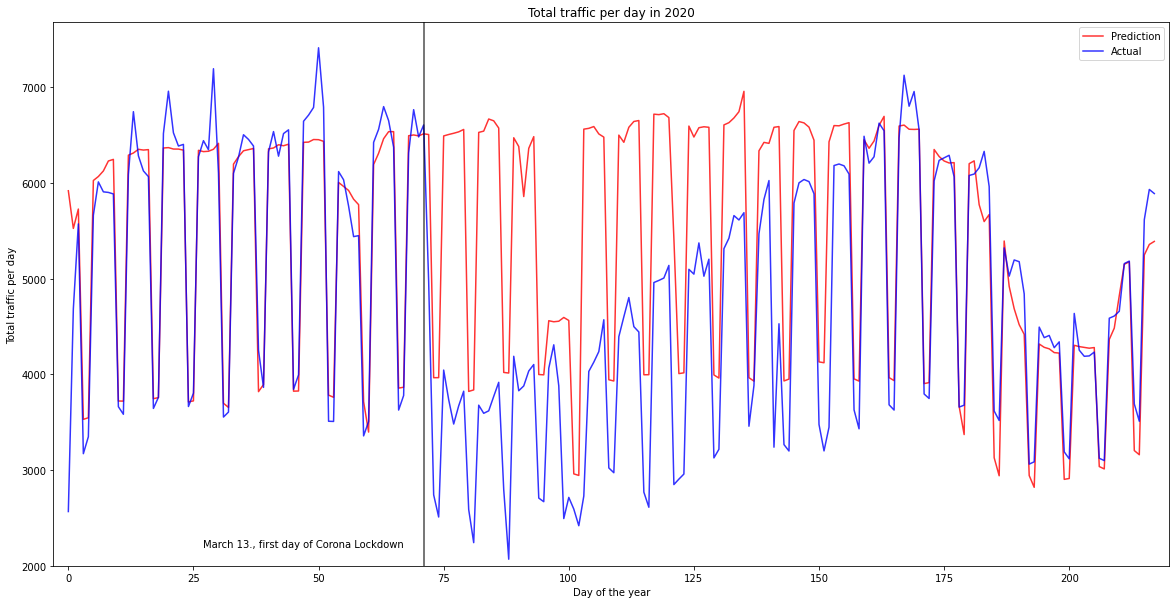

In [51]:
X = traffic_data[["År", "Måned", "Dag", "Fra_time", "sin_hour", "cos_hour", "sin_day", "cos_day", "is_holiday", "is_weekend", "is_DST"]].values
y = traffic_data["Volum totalt"].values
X_test = traffic_data_2020[["År", "Måned", "Dag", "Fra_time", "sin_hour", "cos_hour", "sin_day", "cos_day", "is_holiday", "is_weekend", "is_DST"]].values
y_test = traffic_data_2020["Volum totalt"].values

forest = ens.RandomForestRegressor(max_depth=total_best_depth)
forest.fit(X,  y)
pred_y = forest.predict(X_test)
MAE = mean_absolute_error(y_test, pred_y)

print("On test data, the selected model had a MAE of: %.3f" %MAE)


total_traffic_per_day_2020 = get_total_traffic_per_day(traffic_data_2020)
predicted = pd.DataFrame.copy(traffic_data_2020)
predicted['Volum totalt'] = pred_y
predicted_total_traffic_per_day_2020 = get_total_traffic_per_day(predicted)

first_day_without_data = 0 #2020 only has data up to a certain day, so we cut the remains of the list
for i in range(1, len(predicted_total_traffic_per_day_2020)):
    if predicted_total_traffic_per_day_2020[i] == 1.0: #Data entry with value 1.0 is empty
        first_day_without_data = i
        break

predicted_total_traffic_per_day_2020 = predicted_total_traffic_per_day_2020[1:first_day_without_data]
total_traffic_per_day_2020 = total_traffic_per_day_2020[1:first_day_without_data]
x = list(range(first_day_without_data-1))

fig = plt.figure(figsize=(20,10))
plt.plot(x, predicted_total_traffic_per_day_2020, 'r-', alpha = 0.8, label = "Prediction")
plt.plot(x, total_traffic_per_day_2020, 'b-', alpha = 0.8, label = "Actual")
plt.axvline(x=71, ymin=0, ymax=60000, color = 'k',alpha = 0.7)
plt.text(27, 2200,'March 13., first day of Corona Lockdown')
plt.ylim(bottom=2000)
plt.xlim(left=-3, right=220)
plt.title("Total traffic per day in 2020")
plt.xlabel("Day of the year")
plt.ylabel("Total traffic per day")
plt.legend()
plt.show()